In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 300
img_width = 300

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'ssd300_pascal_07+12_epoch-04_loss-3.0387_val_loss-3.5244_weight.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
start_time = time.time() 
vidcap = cv2.VideoCapture('C:\\Users\\user\Desktop\\video.mp4')
success,imagefile = vidcap.read()
count = 0
while success:
    if(count%5==0):
        cv2.imwrite("C:\\Users\\user\Desktop\\frames\\frame%d.jpg" % count, imagefile)     # save frame as JPEG file      
    success,imagefile = vidcap.read()
    count += 1
    
print("--- %s seconds ---" %(time.time() - start_time))

--- 2.267939567565918 seconds ---


In [11]:
start_time = time.time() 

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

#for문으로 각 리스트에 프레임 단위의 이미지를 여러번 append하면 됨
#frame images에 각각 bounding box -> 함수 이용하여 image들 합쳐서 다시 비디오 생성
#---------------------------여기서부터!!!-----------------------------#

for i in range(0,320):
    if(i%5==0):
        img_path = 'C:\\Users\\user\Desktop\\frames\\frame%d.jpg'%i
        #print(img_path)
        orig_images.append(imread(img_path))
        img = image.load_img(img_path, target_size=(img_height, img_width))
        img = image.img_to_array(img)
        img = np.array(img)
        input_images.append(img)
        
input_images = np.array(input_images)
print("--- %s seconds ---" %(time.time() - start_time))

--- 1.6366384029388428 seconds ---


In [8]:
num_of_frames = 16

y_pred = model.predict(input_images[start_frame:end_frame])

In [9]:
confidence_threshold = 0.4

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
#여기서의 xmin   ymin   xmax   ymax만 저장하면 된다.

for i in range(0, num_of_frames):
    print(y_pred_thresh[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[]
[]
[]
[]
[[  1.     0.54  -1.34   4.34 297.78  79.84]]
[]
[]
[[  1.     0.55  -3.29   4.05 295.4   77.97]]
[[  1.     0.58  -2.55   5.44 294.03  76.97]]
[]
[[  1.     0.56   0.06   5.34 295.19  73.06]]
[]
[]
[[  1.     0.56  -0.12   7.   295.36  74.27]]
[[  1.     0.58   1.08   7.79 297.3   75.73]]
[[  1.     0.61   0.9    7.77 296.71  75.78]]


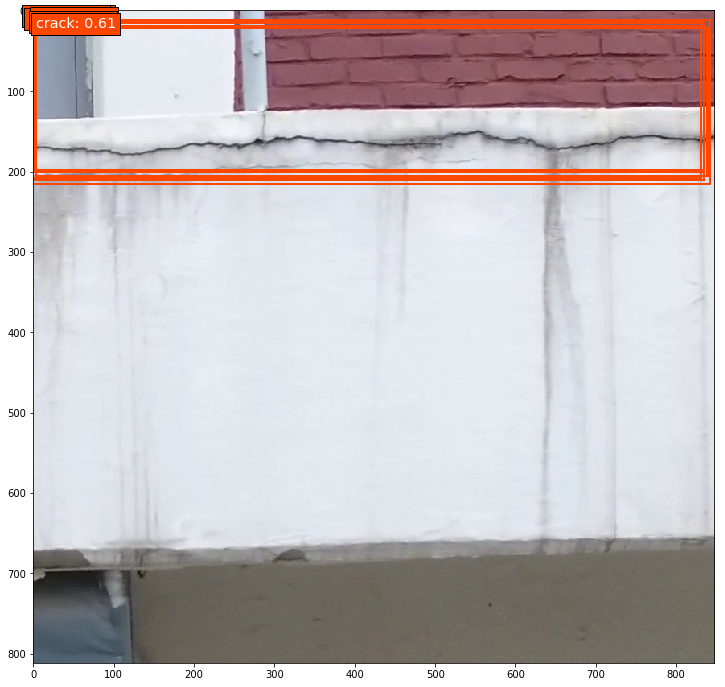

In [10]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background','crack']

plt.figure(figsize=(20,12))

for i in range(0, num_of_frames):
    plt.imshow(orig_images[i])
    current_axis = plt.gca()
    for box in y_pred_thresh[i]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        # box[0] = class, box[1] = conf, box[2] = xmin, box[3] = ymin, box[4] = xmax, box[5] = ymax
        xmin = box[2] * orig_images[i].shape[1] / img_width
        ymin = box[3] * orig_images[i].shape[0] / img_height
        xmax = box[4] * orig_images[i].shape[1] / img_width
        ymax = box[5] * orig_images[i].shape[0] / img_height
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [18]:
cap = cv2.VideoCapture('./sample_video/test_video.mp4')
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('./sample_video/output.avi',fourcc, 3, (int(width), int(height)))
     #cv2.VideoWriter(outputFile, fourcc = 코덱, 윈도우는 DIVX, 초당 frame, 저장될 size)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    # ret : frame capture결과(boolean)
    # frame : Capture한 frame
    
    if ret == True:
        frame = np.asarray(frame)
        results = tfnet.return_predict(frame)

        new_frame = boxing(frame, results)

        # Display the resulting frame
        out.write(new_frame)
        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()

Hello world!


In [26]:
cv2.__version__

'3.4.1'

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.79 143.43  98.45 302.65 295.75]]


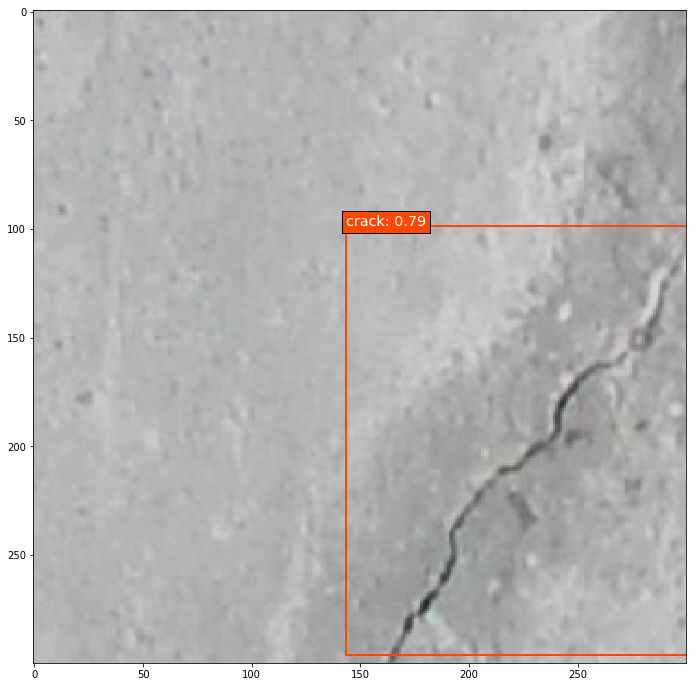

In [81]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'C:\\Users\\user\Desktop\SDNET2018_(300x300)\D(심은지)\CD\\7020-61.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

y_pred = model.predict(input_images)

confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background',
           'crack']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [12]:
len(input_images)

64